In [ ]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parulchaddha947","key":"ace311b5e10fd5d1cf58c4eea549b39b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [ ]:
import zipfile

zip_file = "brain-tumor-mri-dataset.zip"

In [ ]:
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("./brain_tumor_data")

In [ ]:
tr_df_path = "./brain_tumor_data/Training"  # Change to extracted path
labels = []
filepaths = []

folds = os.listdir(tr_df_path)
for fold in folds:
    foldpath = os.path.join(tr_df_path, fold)
    foldlist = os.listdir(foldpath)
    for file in foldlist:
        filepath = os.path.join(foldpath, file)

        labels.append(fold)
        filepaths.append(filepath)

l = pd.Series(labels, name="labels")
f = pd.Series(filepaths, name="filepaths")

tr_df = pd.concat([f, l], axis=1)

print(tr_df.head())

                                           filepaths   labels
0  ./brain_tumor_data/Training/notumor/Tr-no_0315...  notumor
1  ./brain_tumor_data/Training/notumor/Tr-no_0877...  notumor
2  ./brain_tumor_data/Training/notumor/Tr-no_0717...  notumor
3  ./brain_tumor_data/Training/notumor/Tr-no_0399...  notumor
4  ./brain_tumor_data/Training/notumor/Tr-no_1162...  notumor


In [ ]:
tst_df_path="./brain_tumor_data/Testing"
labels=[]
filepaths=[]

folds=os.listdir(tst_df_path)
for fold in folds:
    foldpath=os.path.join(tst_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)

l=pd.Series(labels,name="labels")
f=pd.Series(filepaths,name="filepaths")

ts_df=pd.concat([f,l],axis=1)

In [ ]:
ts_df

filepaths     labels
0     ./brain_tumor_data/Testing/notumor/Te-no_0259.jpg    notumor
1     ./brain_tumor_data/Testing/notumor/Te-no_0316.jpg    notumor
2     ./brain_tumor_data/Testing/notumor/Te-no_0180.jpg    notumor
3     ./brain_tumor_data/Testing/notumor/Te-no_0082.jpg    notumor
4     ./brain_tumor_data/Testing/notumor/Te-no_0150.jpg    notumor
...                                                 ...        ...
1306  ./brain_tumor_data/Testing/pituitary/Te-pi_024...  pituitary
1307  ./brain_tumor_data/Testing/pituitary/Te-pi_016...  pituitary
1308  ./brain_tumor_data/Testing/pituitary/Te-pi_015...  pituitary
1309  ./brain_tumor_data/Testing/pituitary/Te-pi_017...  pituitary
1310  ./brain_tumor_data/Testing/pituitary/Te-pi_016...  pituitary

[1311 rows x 2 columns]

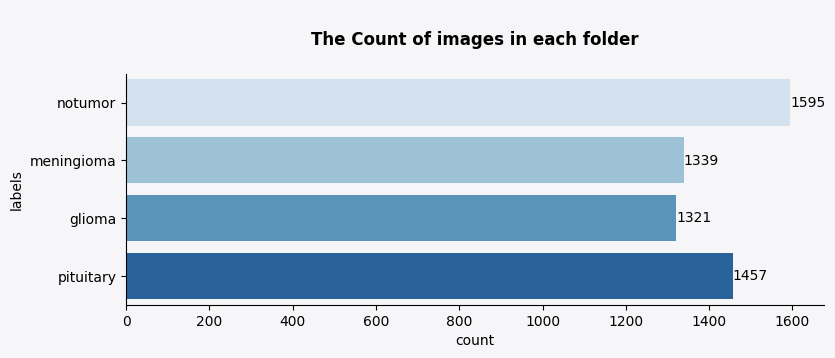

In [ ]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["top","right"]:
    ax.spines[i].set_visible(False)

x = sns.countplot(data=tr_df, y=tr_df["labels"],palette='Blues')
for container in x.containers:
    x.bar_label(container)
plt.title("\nThe Count of images in each folder\n",weight="bold");

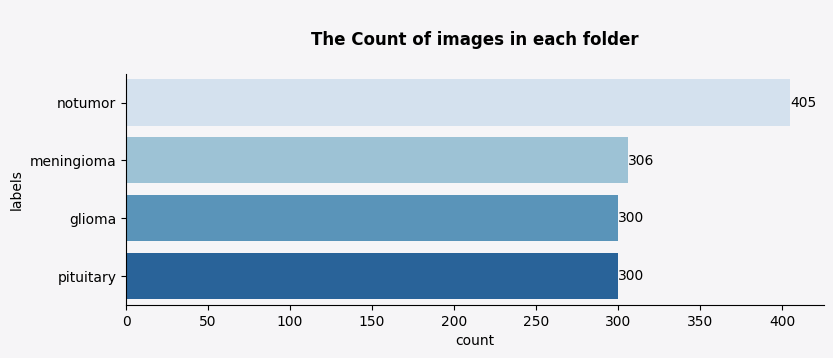

In [ ]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    ax.spines[i].set_visible(False)

i=sns.countplot(data=ts_df,y=ts_df["labels"],palette='Blues')
for container in i.containers:
    i.bar_label(container)

plt.title("\nThe Count of images in each folder\n",weight="bold");

In [ ]:
ts_df.shape

(1311, 2)

In [ ]:
valid_df,tst_df=train_test_split(ts_df,test_size=0.5,random_state=50,stratify=ts_df["labels"])
print(f"ts_df shape: {ts_df.shape}")
print("---"*10)
print(f"valid data shape: {valid_df.shape}")
print(f"test data shape: {tst_df.shape}")

ts_df shape: (1311, 2)
------------------------------
valid data shape: (655, 2)
test data shape: (656, 2)


In [ ]:
valid_df

filepaths      labels
18    ./brain_tumor_data/Testing/notumor/Te-no_0031.jpg     notumor
1275  ./brain_tumor_data/Testing/pituitary/Te-pi_011...   pituitary
488   ./brain_tumor_data/Testing/meningioma/Te-me_01...  meningioma
985    ./brain_tumor_data/Testing/glioma/Te-gl_0255.jpg      glioma
202   ./brain_tumor_data/Testing/notumor/Te-no_0274.jpg     notumor
...                                                 ...         ...
708   ./brain_tumor_data/Testing/meningioma/Te-me_01...  meningioma
1143  ./brain_tumor_data/Testing/pituitary/Te-pi_005...   pituitary
79    ./brain_tumor_data/Testing/notumor/Te-no_0065.jpg     notumor
393   ./brain_tumor_data/Testing/notumor/Te-no_0370.jpg     notumor
314   ./brain_tumor_data/Testing/notumor/Te-no_0115.jpg     notumor

[655 rows x 2 columns]

In [ ]:
img_size=(224,224)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

train_gen=tr.flow_from_dataframe(tr_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


valid_gen=ts.flow_from_dataframe(ts_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16,)


test_gen=ts.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


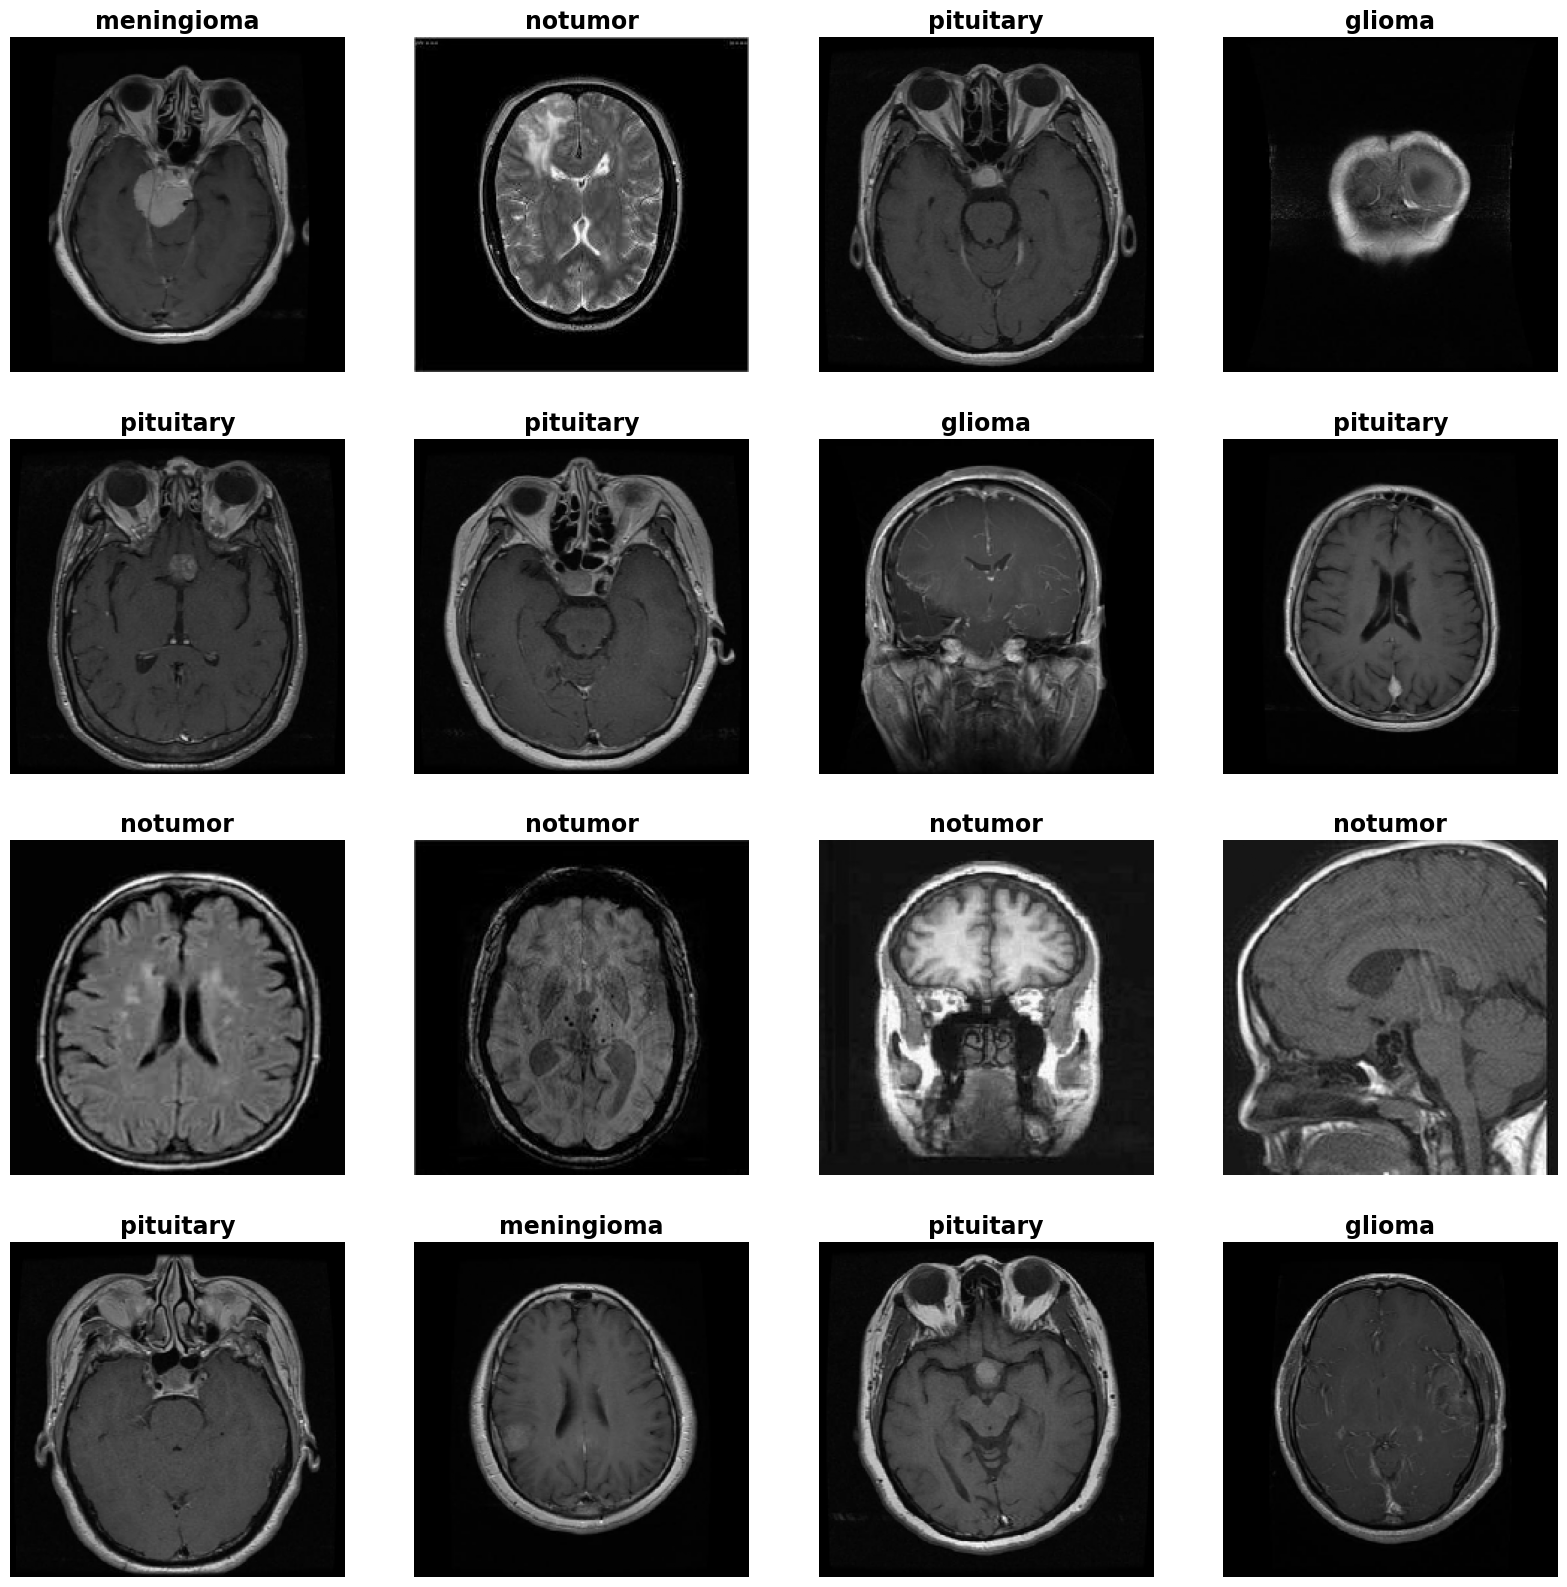

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
    plt.axis('off')
plt.show()

In [ ]:
img_shape=(224,224,3)
base_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

Model = Sequential([
    base_Model,
    Dropout(rate= 0.5),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

Model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
tf.keras.utils.plot_model(base_Model,show_shapes=True)

In [ ]:
historyy=Model.fit(train_gen,epochs=10,
                  validation_data=valid_gen,
                  shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 152s 275ms/step - accuracy: 0.7435 - loss: 0.6703 - val_accuracy: 0.9558 - val_loss: 0.1248
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 86s 240ms/step - accuracy: 0.9697 - loss: 0.0901 - val_accuracy: 0.9611 - val_loss: 0.1143
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.9844 - loss: 0.0501 - val_accuracy: 0.9855 - val_loss: 0.0381
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.9910 - loss: 0.0362 - val_accuracy: 0.9725 - val_loss: 0.0812
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.9909 - loss: 0.0304 - val_accuracy: 0.9725 - val_loss: 0.1447
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.9909 - loss: 0.0298 - val_accuracy: 0.9847 - val_loss: 0.0516
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 85s 238ms/step - accuracy: 0.9964 - loss: 0.0177 - val_accuracy: 0.9825 - val_loss: 0.0599
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 90s 252ms/step - accuracy: 0.9963 - loss: 

In [ ]:
historyy.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

<Figure size 2000x800 with 0 Axes>

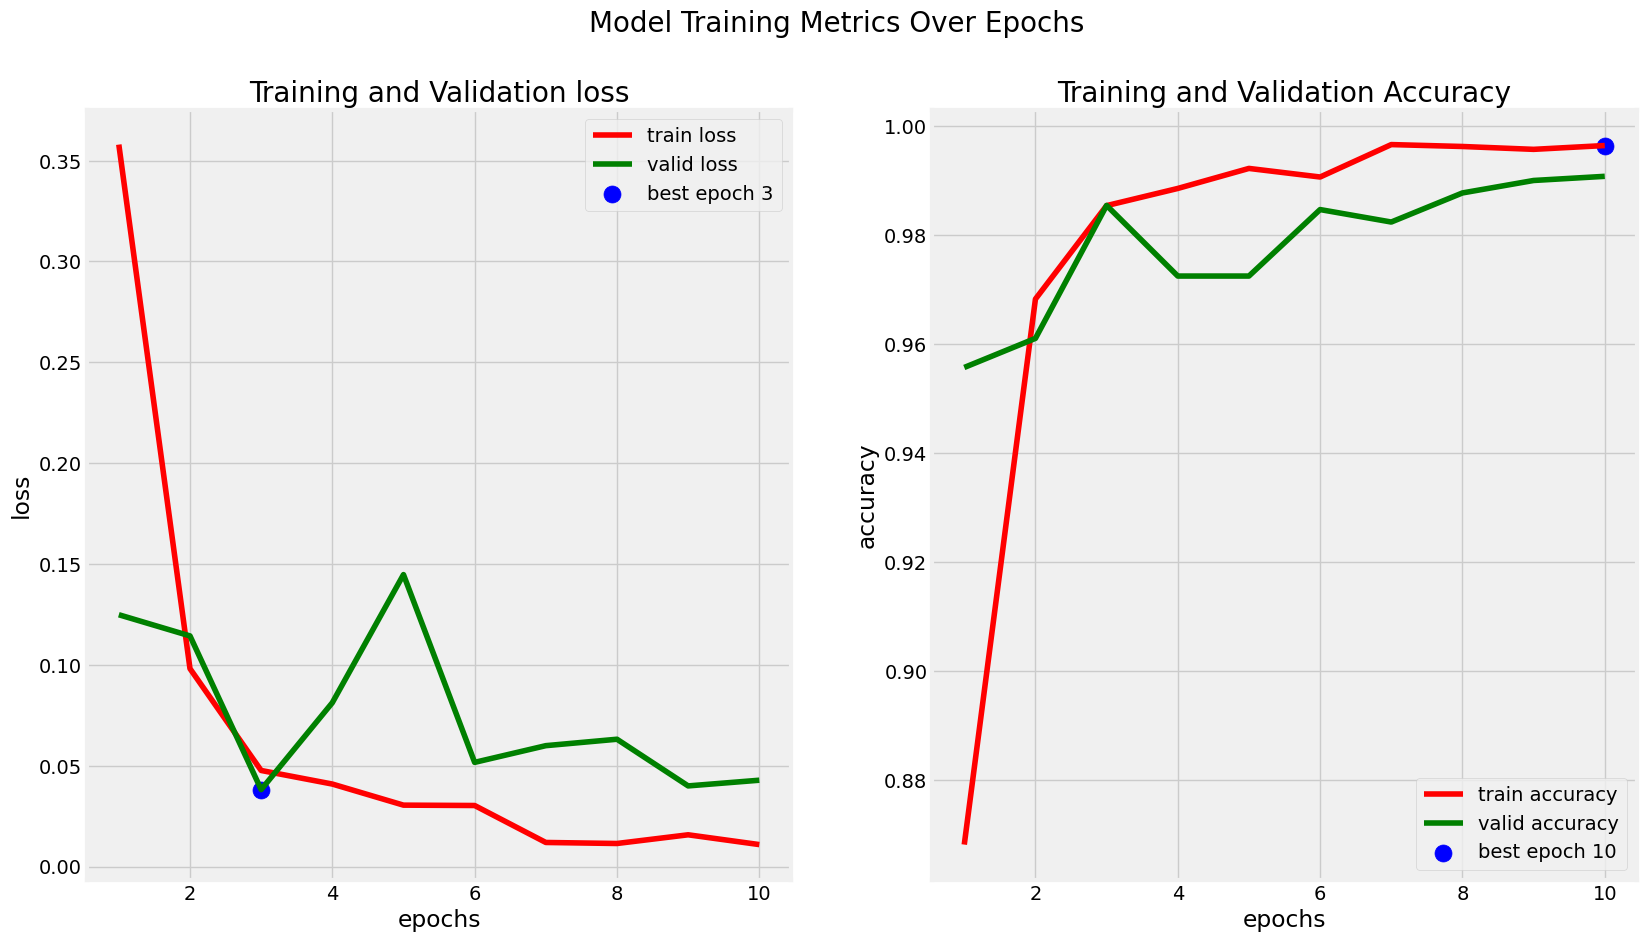

In [ ]:
plt.figure(figsize=(20, 8))
tr_loss=historyy.history["loss"]
val_loss=historyy.history["val_loss"]
index_loss=np.argmin(val_loss)
loss_lowest=val_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

tr_accuracy=historyy.history["accuracy"]
val_accuracy=historyy.history["val_accuracy"]
index_acc=np.argmax(val_accuracy)
acc_highest=tr_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(tr_accuracy))]


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs,tr_loss,"r",label="train loss")
plt.plot(epochs,val_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs,tr_accuracy,"r",label="train accuracy")
plt.plot(epochs,val_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=20);

In [ ]:
train_score=Model.evaluate(train_gen)
valid_score=Model.evaluate(valid_gen)
test_score=Model.evaluate(test_gen)

print(f"Train Loss : {train_score[0]:.3f}")
print(f"Train Accuracy : {train_score[1]*100:.2f}%")
print("-"*20)
print(f"Validation Loss : {valid_score[0]:.3f}")
print(f"Validation Accuracy : {valid_score[1]*100:.2f}%")
print("-"*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.9993 - loss: 0.0036
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9869 - loss: 0.0719
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9912 - loss: 0.0374
Train Loss : 0.008
Train Accuracy : 99.89%
--------------------
Validation Loss : 0.043
Validation Accuracy : 99.08%
--------------------
Test Loss: 0.043
Test Accuracy: 99.08%


In [ ]:
preds=Model.predict(test_gen)
y_pred=np.argmax(preds,axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step


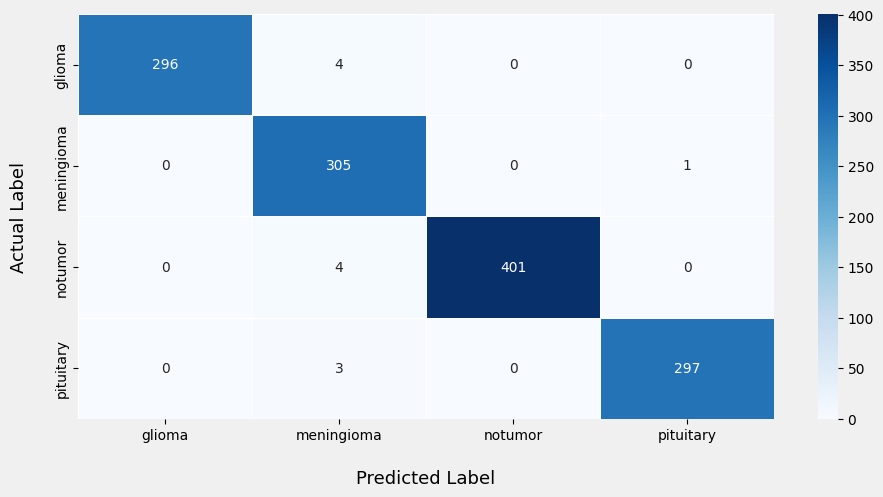

In [ ]:
plt.figure(figsize=(10,5))
plt.style.use('default')
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [ ]:
cr=classification_report(test_gen.classes,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.97      1.00      0.98       306
           2       1.00      0.99      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical

# Convert true labels to one-hot encoding
y_true = to_categorical(test_gen.classes, num_classes=4)

# Compute AUC-ROC score (multi-class, one-vs-rest)
auc_roc = roc_auc_score(y_true, preds, multi_class='ovr')

print(f"AUC-ROC Score: {auc_roc:.4f}")

AUC-ROC Score: 0.9998


In [ ]:
Model.save("image_classifier.h5")

In [ ]:
!pip install streamlit tensorflow numpy pillow pyngrok

In [ ]:
 %%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model("image_classifier.h5")

# Class labels (update based on your dataset)
class_labels = ["Class 1", "Class 2", "Class 3", "Class 4"]

def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize
    return img_array

# Streamlit UI
st.title("Image Classifier")
st.write("Upload an image and get the classification result.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display uploaded image
    img = Image.open(uploaded_file)
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Preprocess image and make prediction
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    # Display prediction
    st.success(f"Prediction: **{class_labels[predicted_class]}**")
    st.info(f"Confidence: **{confidence:.2f}%**")


Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Start Streamlit server
!streamlit run app.py &

# Expose the Streamlit app
public_url = ngrok.connect(port="8501")
print(f"Streamlit is live at: {public_url}")





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.234.240:8501

